In [57]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [58]:
TRAIN_PATH = "data/train_FD001.txt"
TEST_PATH  = "data/test_FD001.txt"
RUL_PATH   = "data/RUL_FD001.txt"

In [ ]:
SEQ_LEN = 30            
STEP = 1               
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 100
PATIENCE = 10
RUL_CLIP = 125       
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [60]:
train_df = pd.read_csv(TRAIN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
test_df  = pd.read_csv(TEST_PATH,  sep=" ", header=None).dropna(axis=1, how="all")
rul_df   = pd.read_csv(RUL_PATH,   sep=" ", header=None)

# consistent columns (first 24 columns typically: unit, cycle, op1..3, s1..21)
cols = ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
train_df = train_df.iloc[:, :len(cols)]
test_df  = test_df.iloc[:, :len(cols)]
train_df.columns = cols
test_df.columns  = cols

In [61]:
train_max = train_df.groupby("unit")["cycle"].max().to_dict()
train_df["RUL"] = train_df.apply(lambda r: train_max[r["unit"]] - r["cycle"], axis=1)
train_df["RUL"] = train_df["RUL"].clip(upper=RUL_CLIP)


In [ ]:
rul_vals = rul_df.iloc[:,0].values.flatten()

test_rul_map = {unit: int(rval) for unit, rval in zip(sorted(test_df["unit"].unique()), rul_vals)}


In [63]:
selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

In [ ]:
train_df = train_df[["unit","cycle"] + selected_features + ["RUL"]]
# test keep features + unit,cycle
test_df = test_df[["unit","cycle"] + selected_features].copy()

scaler = StandardScaler()
train_df[selected_features] = scaler.fit_transform(train_df[selected_features])
test_df[selected_features]  = scaler.transform(test_df[selected_features])

In [65]:
def create_train_sequences(df, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in sorted(df["unit"].unique()):
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        # create windows
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            # label corresponds to last time step of the window (end-1)
            y.append(labels[end-1])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

# Build train sequences for all train units
X_all, y_all = create_train_sequences(train_df, SEQ_LEN, STEP)
print(f"All train sequences: {X_all.shape}, {y_all.shape}")




All train sequences: (17731, 30, 14), (17731,)


In [ ]:
units = sorted(train_df["unit"].unique())
n_units = len(units)
train_units = units[: int(n_units * 0.8)]
val_units   = units[int(n_units * 0.8):]

def create_sequences_by_units(df, units_list, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in units_list:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            y.append(labels[end-1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_sequences_by_units(train_df, train_units, SEQ_LEN, STEP)
X_val,   y_val   = create_sequences_by_units(train_df, val_units,   SEQ_LEN, STEP)

print(f"Train: {X_train.shape}, {y_train.shape}   Val: {X_val.shape}, {y_val.shape}")


Train: (13818, 30, 14), (13818,)   Val: (3913, 30, 14), (3913,)


In [ ]:
def build_test_last_windows(test_df, rul_map, seq_len=SEQ_LEN):
    X_test = []
    y_test = []
    units_sorted = sorted(test_df["unit"].unique())
    for uid in units_sorted:
        unit_df = test_df[test_df["unit"] == uid].reset_index(drop=True)
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(unit_df[selected_features].iloc[[0]].values, pad_len, axis=0)
            window = np.vstack([pad, unit_df[selected_features].values])
        else:
            window = unit_df[selected_features].values[-seq_len:]
        X_test.append(window.astype(np.float32))
        true_rul = rul_map[uid]
        y_test.append(min(true_rul, RUL_CLIP)) 
    return np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32), units_sorted

X_test, y_test, test_units = build_test_last_windows(test_df, test_rul_map, SEQ_LEN)
print(f"Test windows: {X_test.shape}, Test labels (engines): {y_test.shape}")


Test windows: (100, 30, 14), Test labels (engines): (100,)


In [68]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape [N,1]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SeqDataset(X_train, y_train)
val_ds   = SeqDataset(X_val, y_val)
test_ds  = SeqDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out, _ = self.gru(x)          
        last = out[:, -1, :]        
        return self.fc(last)

model = SmallGRU(input_dim=len(selected_features), hidden_dim=64, num_layers=2, dropout=0.2).to(DEVICE)




In [70]:
criterion = nn.SmoothL1Loss()   # Huber-like loss (more robust)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)



In [71]:
best_val = float("inf")
wait = 0
train_losses = []
val_losses = []
best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    model.train()
    tloss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        tloss += loss.item() * Xb.size(0)
    tloss = tloss / len(train_loader.dataset)
    train_losses.append(tloss)

    # Validation
    model.eval()
    vloss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(DEVICE)
            yb = yb.to(DEVICE)
            pred = model(Xb)
            loss = criterion(pred, yb)
            vloss += loss.item() * Xb.size(0)
    vloss = vloss / len(val_loader.dataset)
    val_losses.append(vloss)

    # scheduler step using val loss
    scheduler.step(vloss)

    print(f"Epoch {epoch:03d} | Train: {tloss:.6f} | Val: {vloss:.6f}")

    # early stopping logic
    if vloss < best_val - 1e-6:
        best_val = vloss
        torch.save(model.state_dict(), "best_gru_fd001_fixed.pth")
        wait = 0
        best_epoch = epoch
        print(f"  -> New best val: {best_val:.6f} (saved)")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping (no improvement in {PATIENCE} epochs). Best epoch: {best_epoch}")
            break

# load best model
model.load_state_dict(torch.load("best_gru_fd001_fixed.pth", map_location=DEVICE))


Epoch 001 | Train: 50.068252 | Val: 17.808201
  -> New best val: 17.808201 (saved)
Epoch 002 | Train: 13.628896 | Val: 10.535583
  -> New best val: 10.535583 (saved)
Epoch 003 | Train: 12.030575 | Val: 9.277450
  -> New best val: 9.277450 (saved)
Epoch 004 | Train: 11.661280 | Val: 10.258245
Epoch 005 | Train: 11.423897 | Val: 10.101887
Epoch 006 | Train: 11.263604 | Val: 10.245251
Epoch 007 | Train: 11.221085 | Val: 10.476416
Epoch 008 | Train: 11.077738 | Val: 10.652795
Epoch 009 | Train: 10.821082 | Val: 9.983383
Epoch 010 | Train: 10.735221 | Val: 10.131153
Epoch 011 | Train: 10.499334 | Val: 10.007254
Epoch 012 | Train: 10.443835 | Val: 10.816040
Epoch 013 | Train: 10.414521 | Val: 9.769315
Early stopping (no improvement in 10 epochs). Best epoch: 3


<All keys matched successfully>

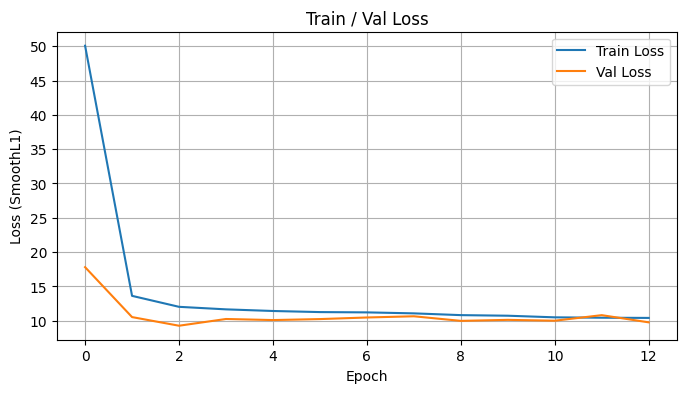

In [72]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (SmoothL1)")
plt.title("Train / Val Loss")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
model.eval()
preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb)                 # shape (batch,1)
        preds.extend(out.cpu().numpy().flatten())

preds = np.array(preds).flatten()
# preds correspond to engines in test_units order
# y_test we built earlier is clipped RUL from rul_map; use that for metric
y_true = y_test.copy()

# compute RMSE (per-engine)
rmse = math.sqrt(mean_squared_error(y_true, preds))
print(f"TEST RMSE (per-engine): {rmse:.6f}")

TEST RMSE (per-engine): 14.911224


In [100]:

print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(test_units, y_true, preds):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}")


Engine | True RUL | Predicted RUL
  1     112.00      113.13
  2      98.00      121.60
  3      69.00       53.69
  4      82.00       99.07
  5      91.00      113.09
  6      93.00      114.92
  7      91.00      110.11
  8      95.00      109.08
  9     111.00      120.95
 10      96.00       84.91
 11      97.00      104.98
 12     124.00      108.61
 13      95.00       75.28
 14     107.00      118.95
 15      83.00      105.65
 16      84.00      101.05
 17      50.00       54.52
 18      28.00       31.23
 19      87.00       83.87
 20      16.00       18.38
 21      57.00       67.44
 22     111.00      121.62
 23     113.00      120.17
 24      20.00       19.76
 25     125.00      111.70
 26     119.00      112.79
 27      66.00      105.93
 28      97.00      109.94
 29      90.00      108.75
 30     115.00      115.04
 31       8.00       12.56
 32      48.00       50.64
 33     106.00      120.51
 34       7.00        5.74
 35      11.00       10.72
 36      19.00      

In [101]:
print("len(y_true):", len(y_true))
print("len(preds):", len(preds))
print("len(test_units):", len(test_units))


len(y_true): 100
len(preds): 100
len(test_units): 100


In [103]:
import torch
import torch.nn as nn

selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SmallGRU(input_dim=len(selected_features), hidden_dim=64, num_layers=2, dropout=0.2).to(DEVICE)

model.load_state_dict(torch.load("best_gru_fd001_fixed.pth", map_location=DEVICE))

model.eval()

print("Loaded model successfully!")


Loaded model successfully!


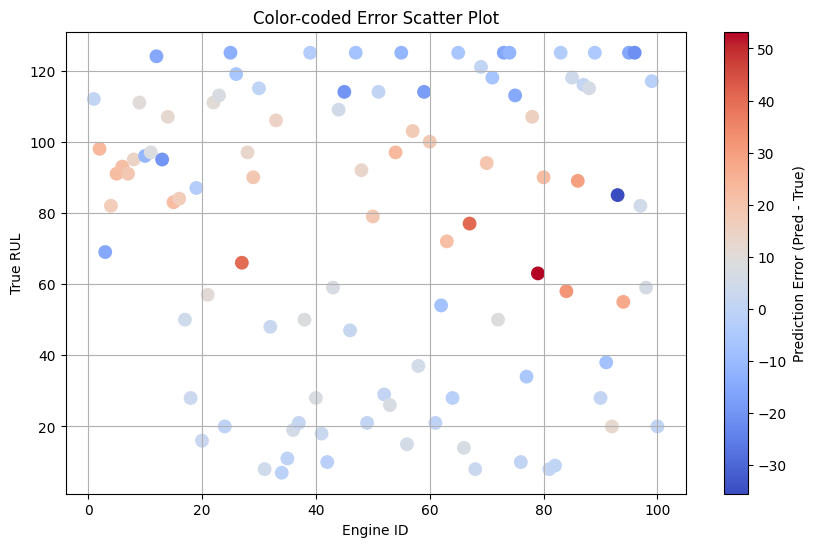

In [104]:
errors = preds - y_true

plt.figure(figsize=(10,6))
plt.scatter(test_units, y_true, c=errors, cmap="coolwarm", s=80)
plt.colorbar(label="Prediction Error (Pred - True)")
plt.xlabel("Engine ID")
plt.ylabel("True RUL")
plt.title("Color-coded Error Scatter Plot")
plt.grid(True)
plt.show()


In [105]:
# %%
import pickle

SCALER_PATH = "scaler_fd001.pkl"

with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved to:", SCALER_PATH)


Scaler saved to: scaler_fd001.pkl


In [106]:
# %%
import pickle
import torch

# Load scaler
with open("scaler_fd001.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Load model
model = SmallGRU(input_dim=len(selected_features), hidden_dim=64, num_layers=2, dropout=0.2)
model.load_state_dict(torch.load("best_gru_fd001_fixed.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Model + Scaler loaded successfully.")


Model + Scaler loaded successfully.


In [113]:
# %%
UNSEEN_PATH = "data/test_FD001.txt"
UNSEEN_TRUE_RUL_PATH = "data/RUL_FD001.txt"   # Must contain RUL values line-by-line

# Load unseen dataset
unseen_df = pd.read_csv(UNSEEN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
unseen_df = unseen_df.iloc[:, :len(cols)]
unseen_df.columns = cols

# Keep only features
unseen_df = unseen_df[["unit","cycle"] + selected_features]

# Apply saved scaler
unseen_df[selected_features] = loaded_scaler.transform(unseen_df[selected_features])

print(unseen_df.head())


   unit  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_2  sensor_3  \
0     1      1      1.055599      1.015677           0.0  0.678077 -0.853550   
1     1      2     -1.230366     -1.031720           0.0 -1.941707 -0.338137   
2     1      3      0.141213      0.333211           0.0 -0.441831 -0.584426   
3     1      4      1.924266     -0.008022           0.0 -0.481827 -1.044384   
4     1      5      0.644125     -0.008022           0.0 -0.341839 -0.543650   

   sensor_4  sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  \
0 -1.191480  0.601408 -0.798093 -0.682579  -1.277396   0.415614  -0.919841   
1 -1.501467  1.674769 -1.220725 -0.490117  -0.154141   1.012195  -0.502695   
2 -0.843717  0.838677 -0.657216 -0.375093  -0.154141   0.754581  -0.919841   
3 -0.279297  0.793483 -0.938970 -0.903570  -0.977861  -0.045381  -0.641744   
4 -0.779276  0.895170 -1.220725 -0.937081  -0.865536   0.998637  -0.919841   

   sensor_14  sensor_15  
0  -0.954235  -0.985107 

In [114]:
# %%
def build_unseen_last_windows(df, seq_len=SEQ_LEN):
    X = []
    units_sorted = sorted(df["unit"].unique())
    
    for uid in units_sorted:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(unit_df[selected_features].iloc[[0]].values, pad_len, axis=0)
            window = np.vstack([pad, unit_df[selected_features].values])
        else:
            window = unit_df[selected_features].values[-seq_len:]
            
        X.append(window.astype(np.float32))
        
    return np.array(X, dtype=np.float32), units_sorted

X_unseen, unseen_units = build_unseen_last_windows(unseen_df, SEQ_LEN)
print("X_unseen shape:", X_unseen.shape)


X_unseen shape: (100, 30, 14)


In [115]:
# %%
true_rul_vals = np.loadtxt(UNSEEN_TRUE_RUL_PATH)
y_unseen = true_rul_vals.astype(np.float32)

print("Loaded true RUL shape:", y_unseen.shape)


Loaded true RUL shape: (100,)


In [116]:
# %%
X_unseen_tensor = torch.tensor(X_unseen, dtype=torch.float32).to(DEVICE)

preds_unseen = []
with torch.no_grad():
    out = model(X_unseen_tensor)
    preds_unseen = out.cpu().numpy().flatten()

preds_unseen = np.array(preds_unseen)


In [117]:
# %%
print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(unseen_units, y_unseen, preds_unseen):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}")

rmse_unseen = math.sqrt(mean_squared_error(y_unseen, preds_unseen))
print("\nUNSEEN DATA RMSE:", rmse_unseen)



Engine | True RUL | Predicted RUL
  1     112.00      113.13
  2      98.00      121.60
  3      69.00       53.69
  4      82.00       99.07
  5      91.00      113.09
  6      93.00      114.92
  7      91.00      110.11
  8      95.00      109.08
  9     111.00      120.95
 10      96.00       84.91
 11      97.00      104.98
 12     124.00      108.61
 13      95.00       75.28
 14     107.00      118.95
 15      83.00      105.65
 16      84.00      101.05
 17      50.00       54.52
 18      28.00       31.23
 19      87.00       83.87
 20      16.00       18.38
 21      57.00       67.44
 22     111.00      121.62
 23     113.00      120.17
 24      20.00       19.76
 25     145.00      111.70
 26     119.00      112.79
 27      66.00      105.93
 28      97.00      109.94
 29      90.00      108.75
 30     115.00      115.04
 31       8.00       12.56
 32      48.00       50.64
 33     106.00      120.51
 34       7.00        5.74
 35      11.00       10.72
 36      19.00      

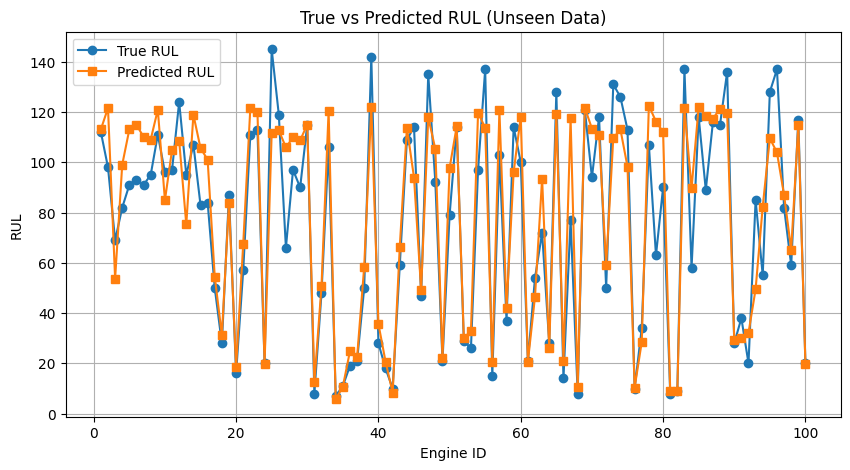

In [118]:
# %%
plt.figure(figsize=(10,5))
plt.plot(unseen_units, y_unseen, marker='o', label="True RUL")
plt.plot(unseen_units, preds_unseen, marker='s', label="Predicted RUL")

plt.title("True vs Predicted RUL (Unseen Data)")
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()
plt.show()


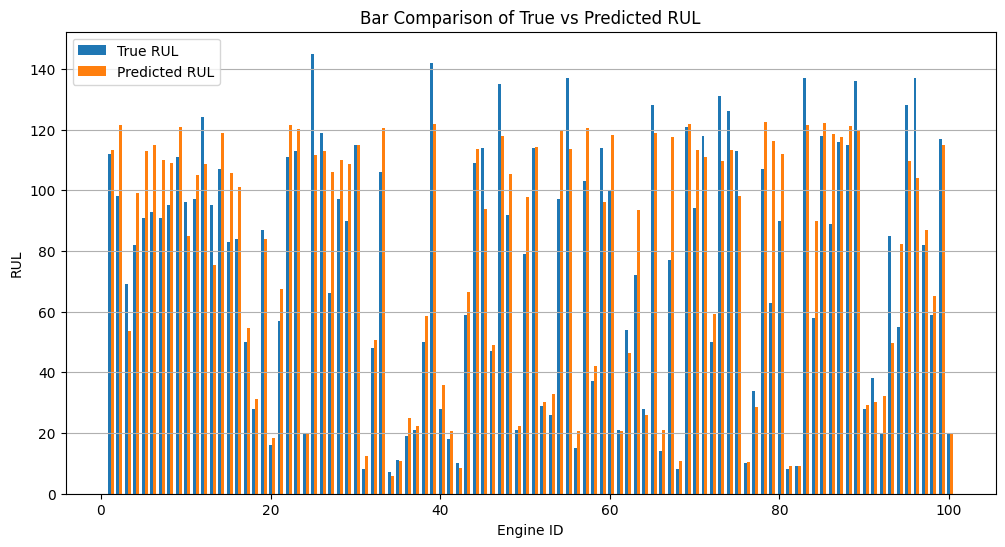

In [119]:
# %%
plt.figure(figsize=(12,6))
width = 0.35

plt.bar(unseen_units, y_unseen, width=width, label="True RUL")
plt.bar(unseen_units + np.array([width]*len(unseen_units)), preds_unseen, width=width, label="Predicted RUL")

plt.title("Bar Comparison of True vs Predicted RUL")
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.legend()
plt.grid(axis='y')
plt.show()
